<a href="https://colab.research.google.com/github/jesvin1/Basics/blob/master/GARCH_ARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://0xboz.github.io/blog/understand-and-model-cryptocurrencies-volatility-using-garch-variants/
https://www.quantconnect.com/tutorials/introduction-to-options/historical-volatility-and-implied-volatility
https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/

In [1]:
from pandas_datareader import data
import pandas as pd
import numpy as np

ticker="^NSEI"


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
# Donloading the data
df = data.DataReader(ticker, 
                       start='2000-1-1', 
                       end='2020-04-17', 
                       data_source='yahoo')

df = df.drop(['High', 'Low', 'Open', 'Close'],axis=1)

# computing log price differences
df['log_price'] = np.log(df['Adj Close'])
df['return'] = df['Adj Close'].pct_change().dropna()
df['log_return'] = df['log_price'] - df['log_price'].shift(1)
#df['squared_log_return'] = np.power(df['log_return'], 2)

# Scale up 100x
df['return_100x'] = np.multiply(df['return'], 100)
df['log_return_100x'] = np.multiply(df['log_return'], 100)

#df['realized_variance'] = pd.Series(df.loc[:, 'squared_log_return'], index=df.index).sum().copy()
#df['realized_volatility'] = np.sqrt(df['realized_variance'])
#df.head()


#df.replace([np.inf, -np.inf], np.nan)
#df.dropna(inplace=True)

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [4]:
adf_test(df['log_return'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.476901e+01
p-value                 2.338246e-27
# lags used             1.100000e+01
# observations          3.057000e+03
critical value (1%)    -3.432491e+00
critical value (5%)    -2.862486e+00
critical value (10%)   -2.567274e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [5]:
!pip install arch

     |████████████████████████████████| 808kB 5.0MB/s 


In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    """
    :params
    :pd_dataframe pandas dataframe
    :observation column name of expected values
    :forecast column name of forecasted values
    :return the results of MAE, MAPE and RMSE, respectively
    """
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot()
    ax.xaxis.label.set_visible(False)
    
    return mae_error, mape_error, rmse_error


In [0]:
from arch import arch_model


------------------------------------------------
Fixed Window Forcasting ARCH
Mean Absolute Error (MAE): 5.43
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 5.82
------------------------------------------------
Fixed Window Forcasting GARCH
Mean Absolute Error (MAE): 3.44
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 4.41
------------------------------------------------
Fixed Window Forcasting EGARCH
Mean Absolute Error (MAE): 2.55
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 3.28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


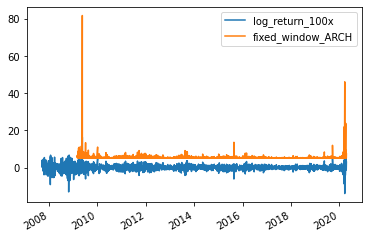

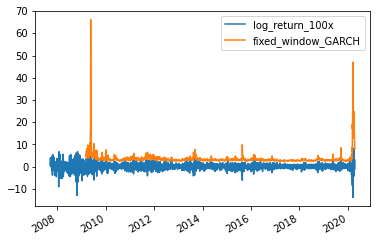

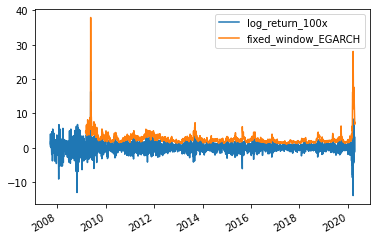

In [12]:
def fixed_window_forecast(pd_dataframe):
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:
        mod = arch_model(pd_dataframe['return_100x'][1:], mean='Zero', vol=model, dist='t')
        res = mod.fit(disp='off', last_obs=356, options={'ftol': 1e-01})
        forecasts = res.forecast()
        pd_dataframe['fixed_window_{}'.format(model)] = forecasts.variance['h.1']
        print('------------------------------------------------')
        print('Fixed Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'log_return_100x', 'fixed_window_{}'.format(model))

fixed_window_forecast(df)


------------------------------------------------
Rolling Window Forcasting ARCH
Mean Absolute Error (MAE): 1.68
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 3.66


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


------------------------------------------------
Rolling Window Forcasting GARCH
Mean Absolute Error (MAE): 1.61
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 3.37


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


------------------------------------------------
Rolling Window Forcasting EGARCH
Mean Absolute Error (MAE): 1.46
Mean Absolute Percentage Error (MAPE): inf
Root Mean Square Error (RMSE): 2.59


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


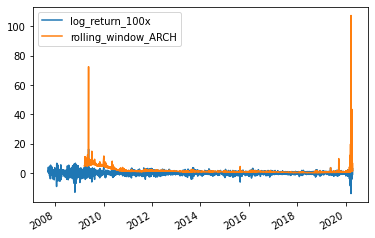

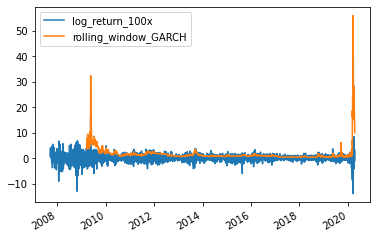

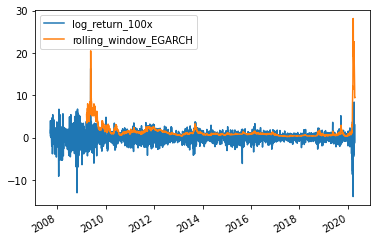

In [16]:
def rolling_window_forecast(pd_dataframe):     

    # Set rolling window
    window = 365
    
    models = ['ARCH', 'GARCH', 'EGARCH']
    for model in models:

        index = df[1:].index
        end_loc = np.where(index >= df.index[window])[0].min()
        forecasts = {}
        for i in range(len(df[1:]) - window + 2):  
            mod = arch_model(pd_dataframe['log_return_100x'][1:], mean='Zero', vol=model, dist='t')
            res = mod.fit(first_obs=i, last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
            temp = res.forecast().variance
            fcast = temp.iloc[i + end_loc - 1]
            forecasts[fcast.name] = fcast

        forecasts = pd.DataFrame(forecasts).T
        pd_dataframe['rolling_window_{}'.format(model)] = forecasts['h.1']
        
        print('------------------------------------------------')
        print('Rolling Window Forcasting {}'.format(model))
        evaluate(pd_dataframe, 'log_return_100x', 'rolling_window_{}'.format(model))
rolling_window_forecast(df)
